In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sleep_stage_classifier.data_model import PSG, Hypnogram
from sleep_stage_classifier.config import DATA_DIR, PARTICIPANT_SHEET_XLS, PARTICIPANT_SHEET

In [3]:
sc_participants = pd.read_excel(
    PARTICIPANT_SHEET_XLS['SC']
)

st_participants = pd.read_excel(
    PARTICIPANT_SHEET_XLS['ST']
)

sc_participants.rename(columns={'subject': 'participant_id'}, inplace=True)
sc_participants['gender'] = sc_participants['sex (F=1)'].apply(lambda x: 'F' if x == 1 else 'M')
sc_participants.drop(columns=['sex (F=1)'], inplace=True)


st_participants.loc[0, 'Subject - age - sex'] = 'participant_id'
st_participants.loc[0, 'Unnamed: 1'] = 'age'
st_participants.loc[0, 'Placebo night'] = 'Placebo night'
st_participants.loc[0, 'Temazepam night'] = 'Temazepam night'
st_participants.loc[0, 'Unnamed: 4'] = 'Placebo night lights off'
st_participants.loc[0, 'Unnamed: 6'] = 'Temazepam night lights off'
st_participants.columns = st_participants.iloc[0]
st_participants = st_participants.drop(0)
st_participants['gender'] = st_participants['M1/F2'].apply(lambda x: 'M' if x == 1 else 'F')
st_participants.drop(columns=['M1/F2'], inplace=True)

night_df = st_participants.melt(id_vars=['participant_id', 'age', 'gender'], value_vars=['Placebo night', 'Temazepam night'], var_name='drug_night', value_name='night')
lights_off_df = st_participants.melt(id_vars=['participant_id', 'age', 'gender'], value_vars=['Placebo night lights off', 'Temazepam night lights off'], var_name='drug_lights_off', value_name='lights off')
night_df['drug'] = night_df['drug_night'].str.extract('(Placebo|Temazepam)')
lights_off_df['drug'] = lights_off_df['drug_lights_off'].str.extract('(Placebo|Temazepam)')
night_df.drop(columns='drug_night', inplace=True)
lights_off_df.drop(columns='drug_lights_off', inplace=True)
st_participants = pd.merge(night_df, lights_off_df, on=['participant_id', 'age', 'gender', 'drug'])

sc_participants.rename(columns={
    'LightsOff': 'lights_off_time'
}, inplace=True)

st_participants.rename(columns={
    'lights off': 'lights_off_time'    
}, inplace=True)

sc_participants['study'] = 'SC' 
st_participants['study'] = 'ST'


In [4]:
columns_interested = ['participant_id', 'night', 'age', 'gender', 'lights_off_time', 'study']
participants = pd.concat([sc_participants[columns_interested], st_participants[columns_interested]], axis=0)
participants['session_id'] = participants.apply(lambda row: f"{row['study']}{'4' if row['study'] == 'SC' else '7'}{str(row['participant_id']).zfill(2)}{row['night']}", axis=1)
participants


,participant_id,night,age,gender,lights_off_time,study,session_id
0,0,1,33,F,00:38:00,SC,SC4001
1,0,2,33,F,21:57:00,SC,SC4002
2,1,1,33,F,22:44:00,SC,SC4011
3,1,2,33,F,22:15:00,SC,SC4012
4,2,1,26,F,22:50:00,SC,SC4021
...,...,...,...,...,...,...,...
39,19,1,28,F,23:44:00,ST,ST7191
40,20,2,24,M,00:01:00,ST,ST7202
41,21,1,34,F,23:10:00,ST,ST7211
42,22,2,56,M,23:44:00,ST,ST7222


In [5]:
assert participants['session_id'].nunique() == participants.shape[0] 

In [6]:
psg_files = [f for f in os.listdir(DATA_DIR) if f.endswith('PSG.edf')]
hypnogram_files = [f for f in os.listdir(DATA_DIR) if f.endswith('Hypnogram.edf')]
len(psg_files), len(hypnogram_files), participants.shape[0]

(197, 197, 197)

In [7]:
session_to_files = {}

for session_id in tqdm(participants['session_id']):
    session_to_files[session_id] = {
        'psg_file': None,
        'hypnogram_file': None
    }
    for f in psg_files:
        if session_id in f:
            session_to_files[session_id]['psg_file'] = f
            break
    for f in hypnogram_files:
        if session_id in f:
            session_to_files[session_id]['hypnogram_file'] = f
            break
    
    assert session_to_files[session_id]['psg_file'] is not None and session_to_files[session_id]['hypnogram_file'] is not None, f"Missing files for {session_id}"

100%|██████████| 197/197 [00:00<00:00, 89754.28it/s]


In [8]:
def get_file_path(session_id, file_type):
    file_name = session_to_files[session_id][f"{file_type}_file"]
    return os.path.join(DATA_DIR, file_name)

participants['psg_file'] = participants['session_id'].apply(lambda x: get_file_path(x, 'psg'))
participants['hypnogram_file'] = participants['session_id'].apply(lambda x: get_file_path(x, 'hypnogram'))

In [9]:
participants.to_csv(PARTICIPANT_SHEET, index=False)

In [10]:
psg_file = participants.iloc[0]['psg_file']
hypnogram_file = participants.iloc[0]['hypnogram_file']

psg = PSG(psg_file)
hypnogram = Hypnogram(hypnogram_file)

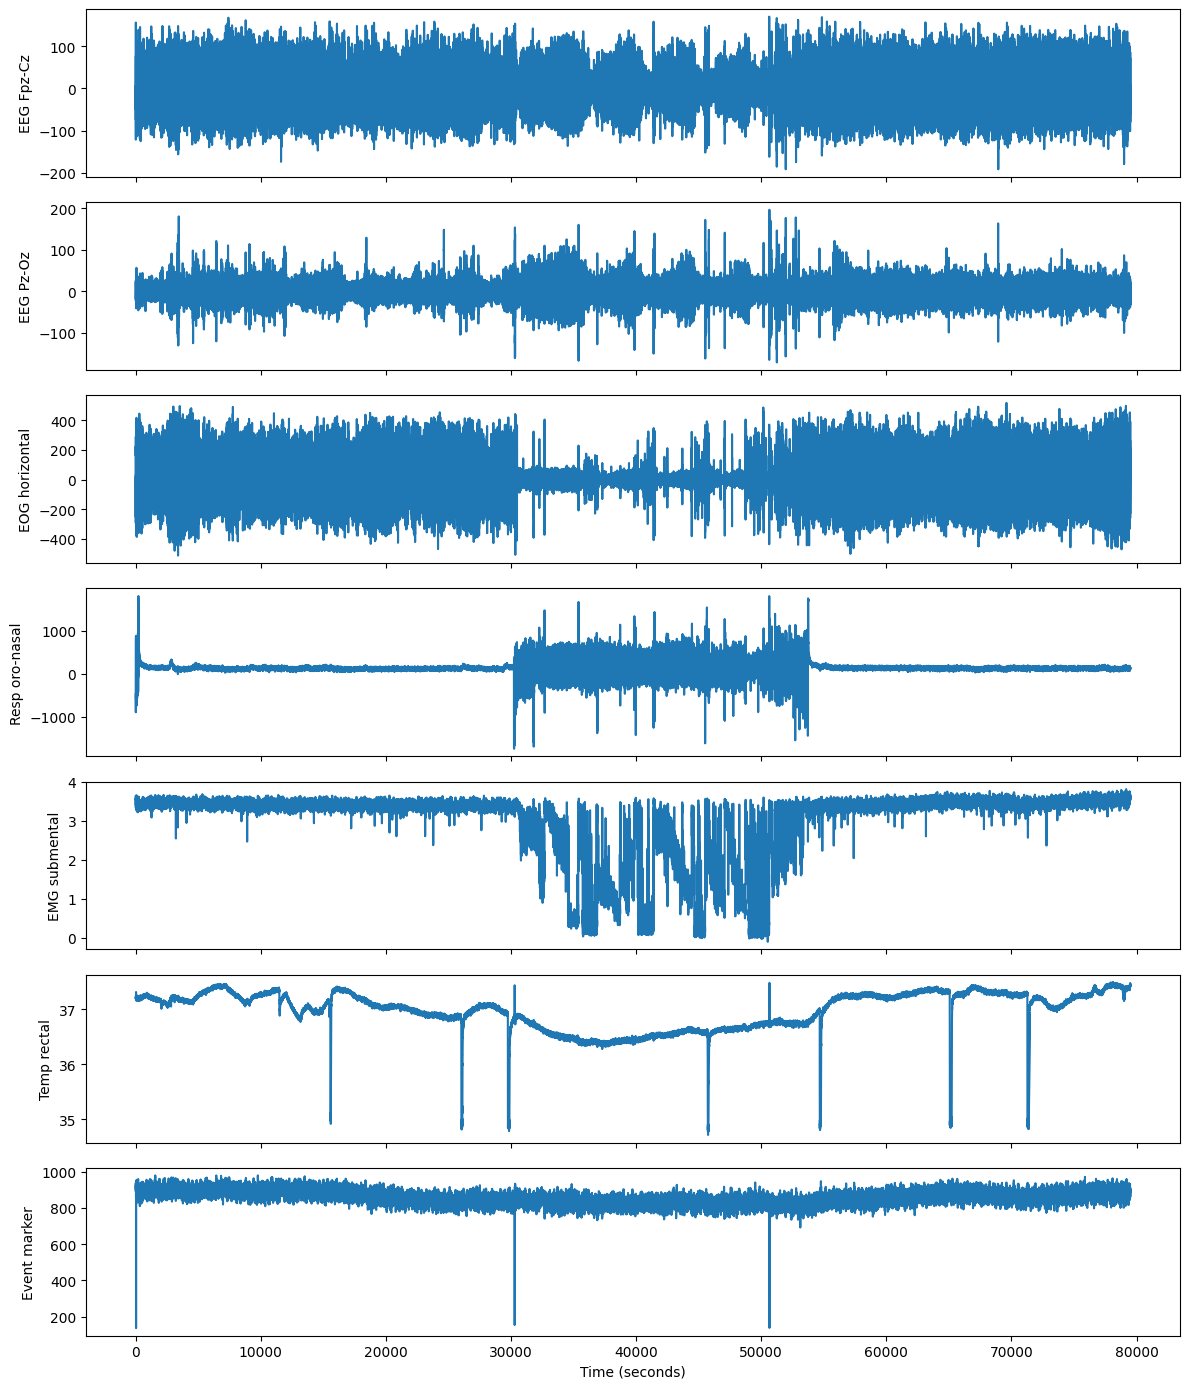

In [17]:
psg.plot_signals()

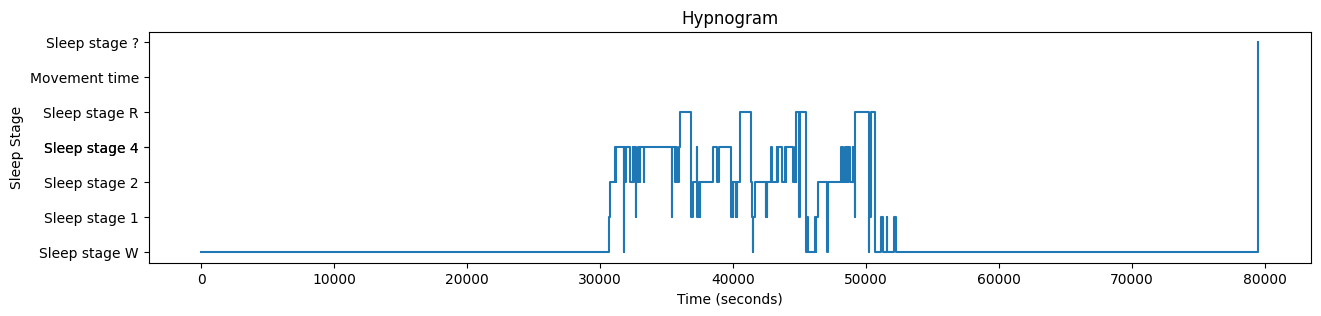

In [19]:
hypnogram.plot_stages()

In [22]:
from sleep_stage_classifier.data_viz.plotting import plot_all_signals_with_stages

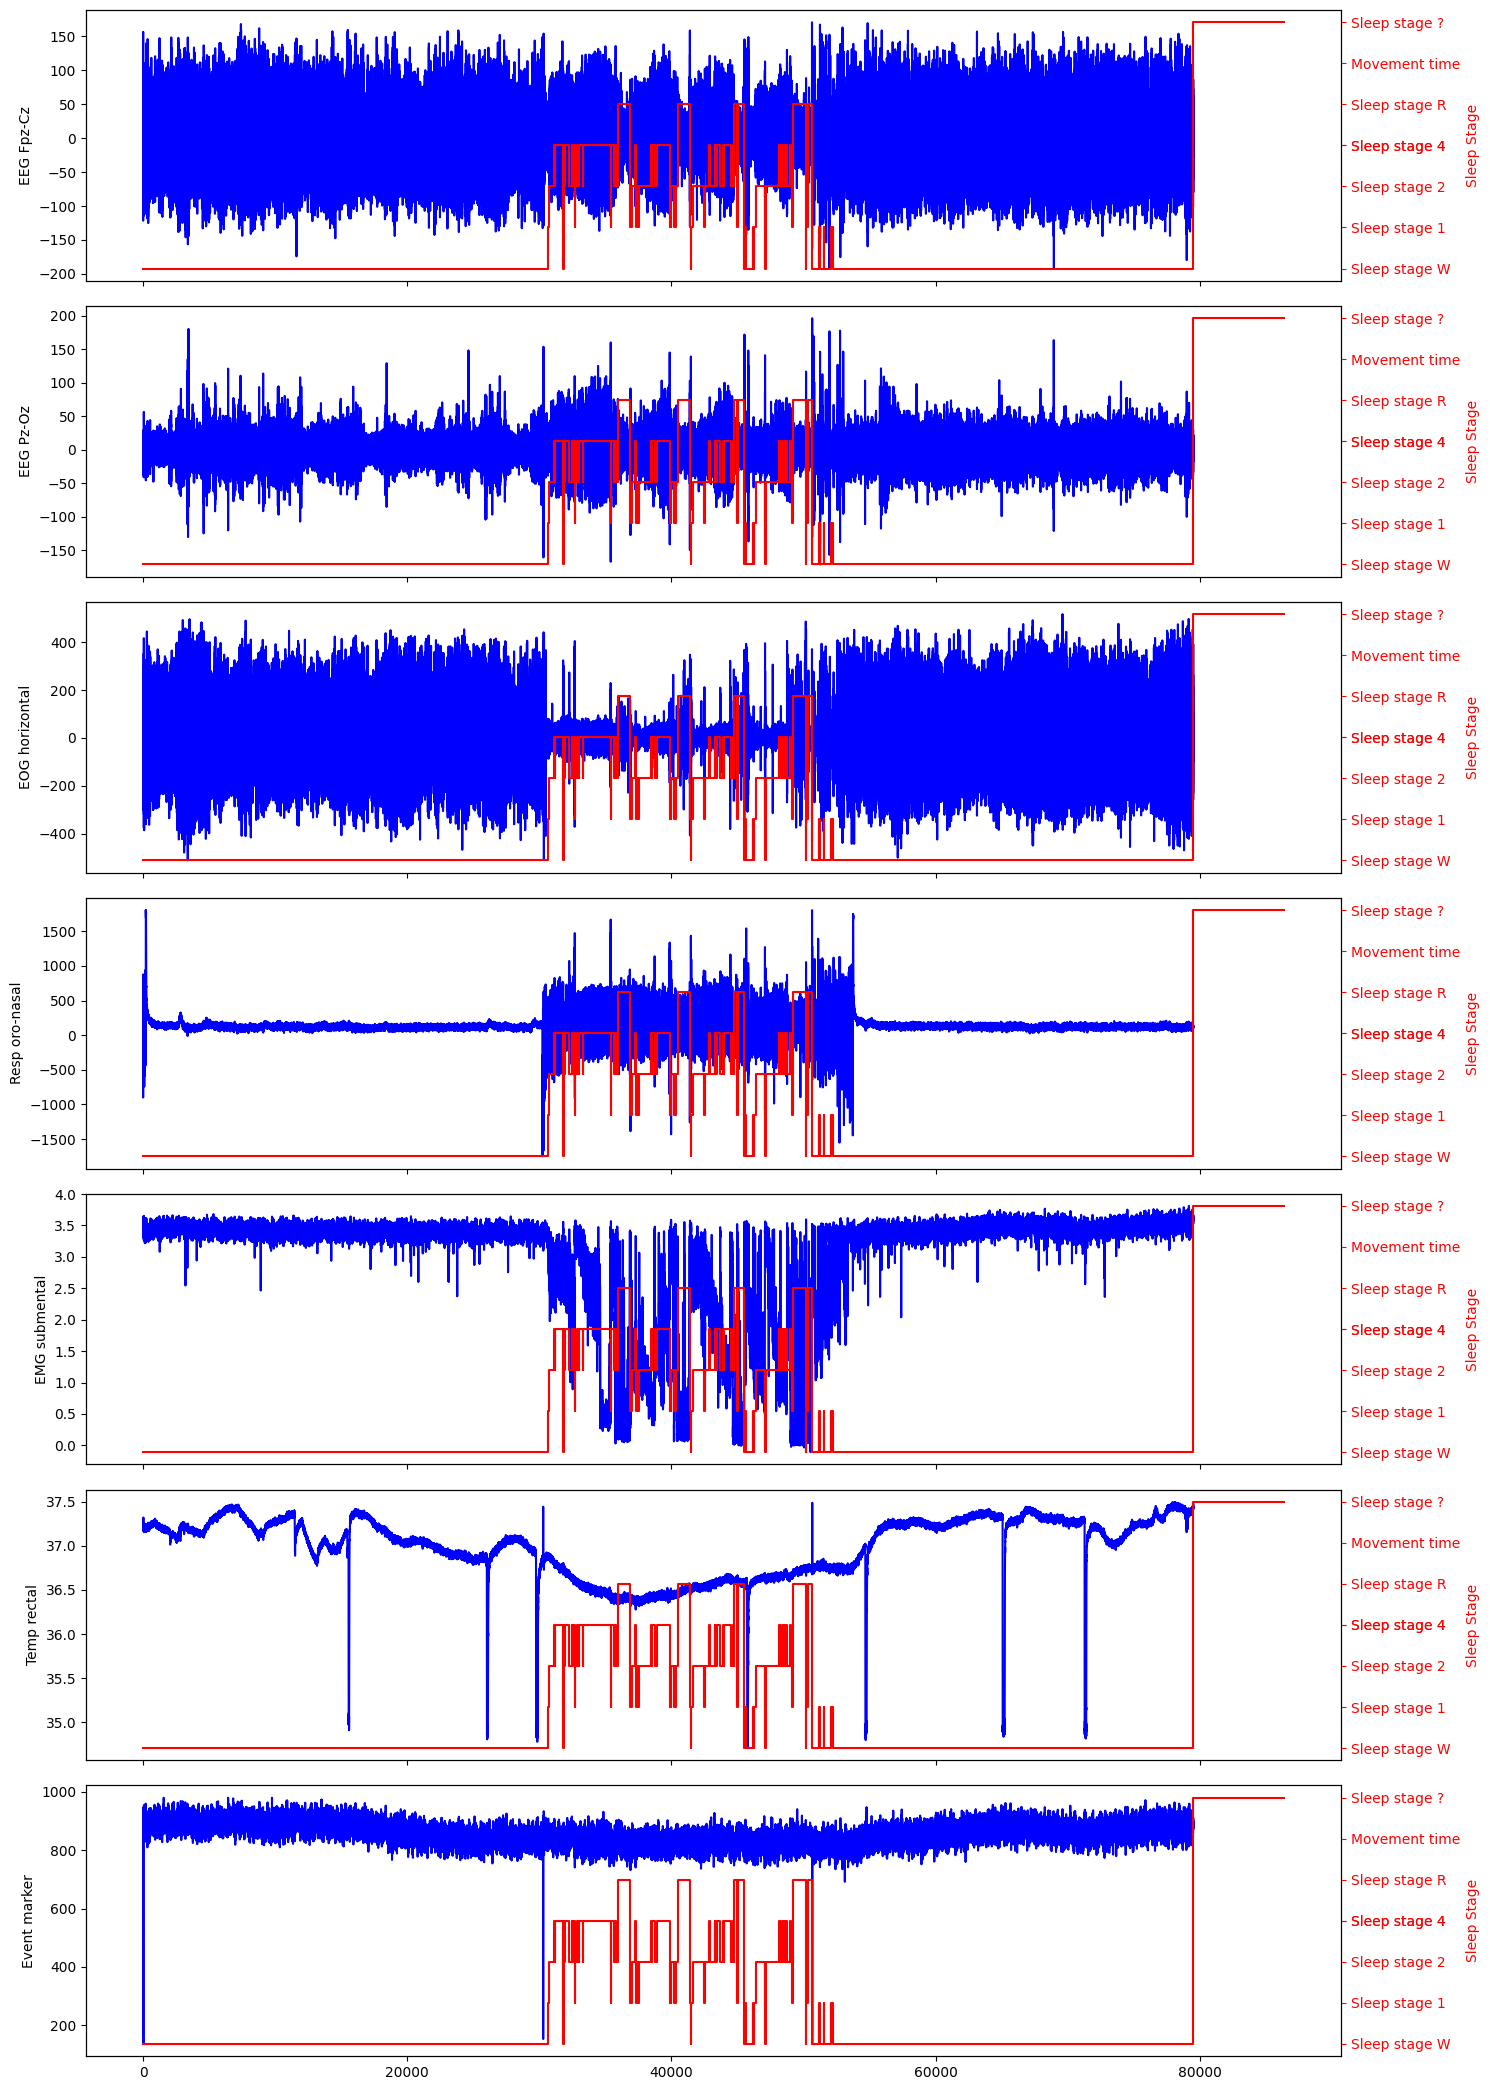

In [25]:
plot_all_signals_with_stages(psg, hypnogram)

### Dataset Overview: Polysomnographic (PSG) Signals and Hypnogram Annotations

The plots presented here are part of the dataset exploration for the "SleepStageClassifier" machine learning project. This dataset consists of paired PSG recordings and hypnogram annotations from the sleep-edf database, which are used to classify sleep stages.

#### PSG Recordings
- **Polysomnographic Signals:** The PSG dataset includes a comprehensive collection of physiological signals that are typically used to study sleep patterns and diagnose sleep disorders:
  - **EEG (Electroencephalogram):** Measures brain's electrical activity.
  - **EOG (Electrooculogram):** Captures eye movements, particularly important for identifying REM sleep.
  - **EMG (Electromyogram):** Assesses muscle activity and tone, providing insights into different sleep stages, especially REM sleep and awakenings.

Each signal is plotted over time, with the x-axis representing the time in 30-second epochs (standard for sleep stage analysis) and the y-axis displaying the signal amplitude.

(Note: when we refer to a 30-second epoch, we mean that the x-axis shows time in seconds, but each labeled point or division represents the end of a 30-second interval. This standard epoch duration is chosen because it is long enough to capture the necessary physiological data to identify sleep stages but short enough to provide a detailed view of the sleep cycle progression throughout the night.)

#### Hypnogram Annotations
- **Sleep Stages:** The hypnogram file contains annotations for the corresponding sleep stages, identified during the PSG recording. The stages are plotted against time and show the progression through various sleep phases:
  - **W (Wakefulness)**
  - **N1 (Non-REM Stage 1)**
  - **N2 (Non-REM Stage 2)**
  - **N3 (Non-REM Stage 3, Deep Sleep)**
  - **REM (Rapid Eye Movement Sleep)**

